In [101]:
import pandas as pd 
import seaborn as sns 
import numpy as np 
import matplotlib.pyplot as plt 
from imblearn.over_sampling import SMOTE
import utils.data_utils as du

In [102]:
data = pd.read_csv("./raw_data/GSE45827_series_matrix.txt", sep = "\t", comment = "!")

In [103]:
data = data.dropna(axis = 0) 

In [104]:
soft_map = pd.read_csv("./raw_data/GPL570-55999.txt", sep = "\t", comment = "#", dtype = object)
soft_map = soft_map.loc[:, ['ID', 'Gene Symbol']]
soft_map

,ID,Gene Symbol
0,1007_s_at,DDR1 /// MIR4640
1,1053_at,RFC2
2,117_at,HSPA6
3,121_at,PAX8
4,1255_g_at,GUCA1A
...,...,...
54670,AFFX-ThrX-5_at,NaN
54671,AFFX-ThrX-M_at,NaN
54672,AFFX-TrpnX-3_at,NaN
54673,AFFX-TrpnX-5_at,NaN


In [105]:
soft_map.set_index("ID", inplace = True) 

soft_map = soft_map.loc[data['ID_REF']]
soft_map

,Gene Symbol
ID,
1007_s_at,DDR1 /// MIR4640
1053_at,RFC2
117_at,HSPA6
1294_at,MIR5193 /// UBA7
1316_at,THRA
...,...
91684_g_at,EXOSC4
91703_at,EHBP1L1
91816_f_at,MEX3D


In [106]:
soft_map.dropna(axis = 0, inplace = True)
soft_map['Gene Symbol'] = list(map(lambda x: x.split("///")[0], soft_map['Gene Symbol']))

In [107]:
data.set_index("ID_REF", inplace= True) 

data.index = data.index.map(dict(zip(soft_map.index, soft_map['Gene Symbol'])))

In [108]:
data = data[data.index.notnull()]
data.index.isnull().sum()

np.int64(0)

In [109]:
metadata = du.get_metadata("./raw_data/GSE45827_series_matrix.txt")

diagnosis_str = du.filter_characteristic(metadata, "diagnosis")
diagnosis_str = diagnosis_str[0]

In [110]:
data = data.T
data['diagnosis'] = list(map(lambda x: x.strip("\""), diagnosis_str.split("\t")[1:]))

In [111]:
cell_line_list = du.filter_diagnosis_string(diagnosis_str, keyword = "cell line")

In [112]:
data = data[~data['diagnosis'].isin(cell_line_list)]

In [113]:
inputs = data.drop("diagnosis", axis = 1) 
labels = data['diagnosis']

In [114]:
from sklearn.preprocessing import StandardScaler 

st_scalar = StandardScaler() 

inputs = st_scalar.fit_transform(inputs) 

In [115]:
smote_augmentor = SMOTE(sampling_strategy="minority", random_state=1)

inputs, labels = smote_augmentor.fit_resample(inputs, labels) 

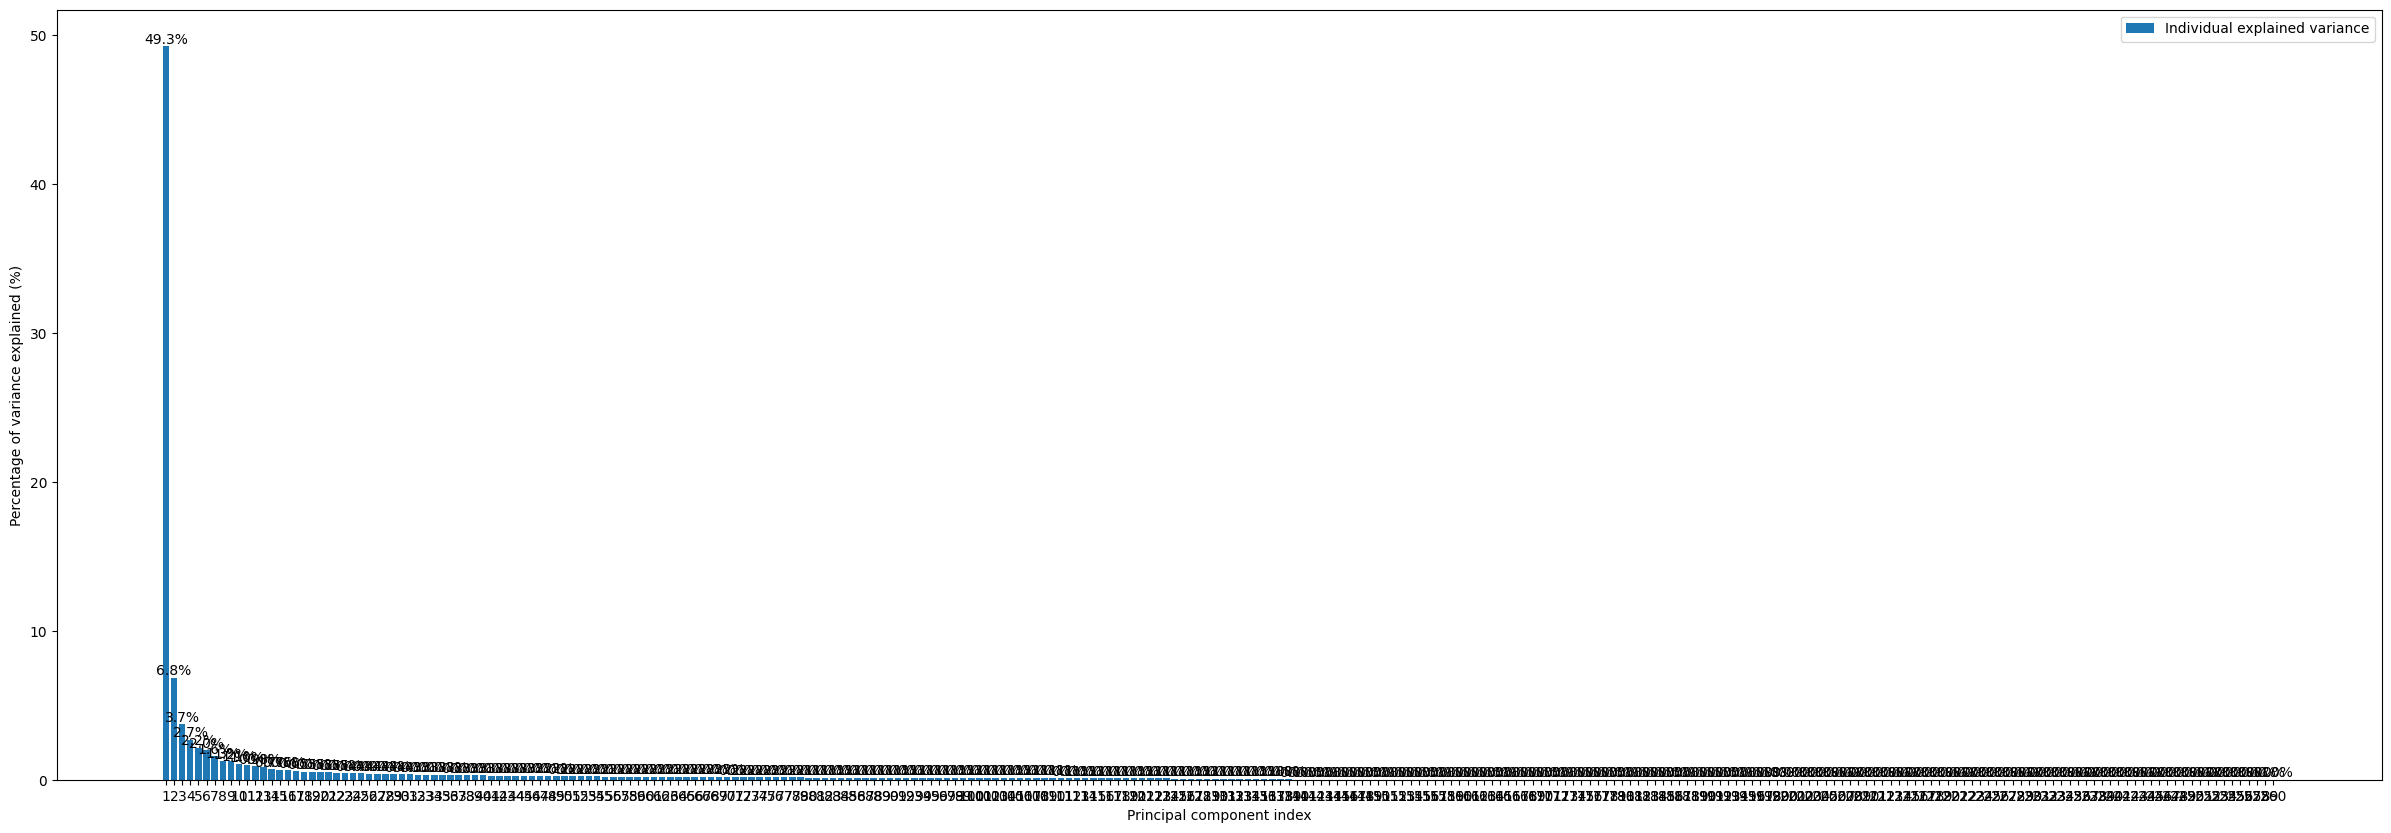

In [116]:
cov_mat = np.cov(inputs)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

exp_var = []

# Sort the eigenvalues in descending order
eigen_vals = np.sort(eigen_vals)[::-1]

for i in eigen_vals:
  var = (i / np.sum(eigen_vals)) * 100
  exp_var.append(var)


figure = plt.figure(figsize = (30, 10))

bar = plt.bar(range(1, len(exp_var)+1), list(map(np.real, exp_var)), 
        label='Individual explained variance')

#Adding data labels to the top of bars 
for i, bar in enumerate(bar):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{round(exp_var[i].real, 1)}%', 
             ha='center', va='bottom')

plt.ylabel('Percentage of variance explained (%)')
plt.xlabel('Principal component index')
plt.xticks(ticks=list(range(1, len(exp_var)+1)))
plt.legend(loc='best')


In [117]:
from sklearn.decomposition import PCA 

pca = PCA(n_components=3) 

new_data = pca.fit_transform(inputs) 

In [118]:
label_keys = list(labels.unique() )

y_labels = np.array( [1 if i == label_keys[0] else 0 for i in labels])

inputs = new_data

In [119]:
from sklearn.model_selection import train_test_split 

x_train, x_test, y_train, y_test = train_test_split(inputs, y_labels, test_size=0.3) 

[[33  0]
 [ 0 45]]


<Axes: >

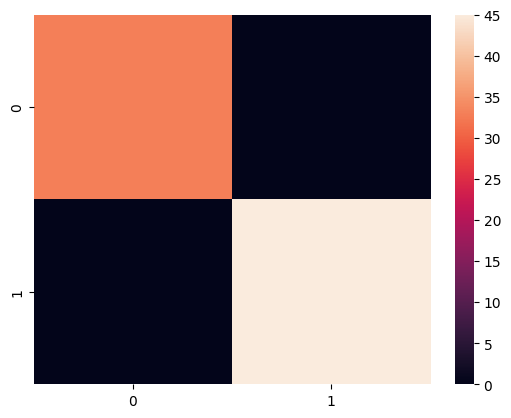

In [120]:
from sklearn.svm import SVC 
from sklearn.metrics import confusion_matrix, classification_report 

classifier = SVC(kernel='linear') 

classifier = classifier.fit(x_train, y_train) 

predictions = classifier.predict(x_test) 

cf_matrix = confusion_matrix(y_test, predictions) 

print(cf_matrix)

sns.heatmap(cf_matrix)

In [121]:
def make_svm_equation(classifier: SVC): 

    coeficients = classifier.coef_[0]
    intercept = classifier.intercept_[0] 

    def make_equation(xx, yy): 

        z = -1 * (coeficients[0] * xx + coeficients[1] *yy + intercept)/coeficients[2]
        return z

    return make_equation 

In [122]:
svm_equation = make_svm_equation(classifier) 

x_points, y_points = np.meshgrid(np.linspace(inputs[:, 0].min(), inputs[:, 0].max(), 10), 
                                 np.linspace(inputs[:, 1].min(), inputs[:, 1].max(), 10))


z_points = svm_equation(x_points, y_points)

In [123]:
import plotly.express as px 

figure = px.scatter_3d(
    pd.DataFrame(new_data, columns = ['pc1', 'pc2', 'pc3']),
    color = labels,
    labels = labels,  
    x = 'pc1',
    y = 'pc2',
    z = 'pc3',
    opacity = 0.8,
    width = 800,
    height = 500)

figure.update_layout(coloraxis_showscale = False, showlegend = True)

figure.show() 
figure.write_image("./output_plots/pca-plot.png")

In [124]:
import plotly.graph_objects as go 

surface_trace = go.Surface(x = x_points, y = y_points, z = z_points, showscale = False)

figure.add_trace(surface_trace)

figure.update_layout(scene=dict(
    zaxis=dict(range=[inputs[:, 2].min(), inputs[:, 2].max()]),
    xaxis = dict(range = [inputs[:, 0].min(), inputs[:, 0].max()]), 
    yaxis = dict(range = [inputs[:, 1].min(), inputs[:, 1].max()]), 
    aspectmode = 'manual',
    aspectratio = dict(x =1.2, y=1, z = 0.6),
))

figure.show() 
figure.write_image("./output_plots/hyperplane-plot.png")